In [1]:
from keras.models import Model, Input
import keras.backend as K
from keras.optimizers import Nadam, SGD, Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import os
import sys
import numpy as np
from keras.utils import to_categorical
import tensorflow as tf

Using TensorFlow backend.


In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";

# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

In [3]:
import glob
import random
import string
import unicodedata
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time
import math

In [4]:
random.seed(30)

In [5]:
def findFiles(path): 
    return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_chars
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [6]:
print('all training files=',findFiles('data/names/*.txt'))

pad_char = '#'
all_chars = string.ascii_letters + " .,;'" + pad_char
n_chars = len(all_chars)

print(unicodeToAscii('Ślusàrski'))

# Build the category_names dictionary, a list of names per language
category_names_dict = {}
all_categories = []

name_counts = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    names = readLines(filename)
    category_names_dict[category] = names
    name_counts.append(len(names))

num_samples = np.sum(name_counts)
n_categories = len(all_categories)

print('Total ',num_samples,'names across',n_categories,'categories')

all training files= ['data/names/Vietnamese.txt', 'data/names/Czech.txt', 'data/names/Spanish.txt', 'data/names/Arabic.txt', 'data/names/Irish.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/French.txt', 'data/names/Italian.txt', 'data/names/Greek.txt', 'data/names/Korean.txt', 'data/names/Japanese.txt', 'data/names/Polish.txt', 'data/names/Chinese.txt', 'data/names/German.txt', 'data/names/Russian.txt', 'data/names/Portuguese.txt', 'data/names/English.txt']
Slusarski
Total  20074 names across 18 categories


In [7]:
print('No of characters, this is the encoding dimension of each character in a name : ',n_chars)

No of characters, this is the encoding dimension of each character in a name :  58


In [8]:
print('all_categories=',all_categories,'\n')
print('category "English" has ',len(category_names_dict['English']),'names')
print(category_names_dict['English'][:5])

all_categories= ['Vietnamese', 'Czech', 'Spanish', 'Arabic', 'Irish', 'Scottish', 'Dutch', 'French', 'Italian', 'Greek', 'Korean', 'Japanese', 'Polish', 'Chinese', 'German', 'Russian', 'Portuguese', 'English'] 

category "English" has  3668 names
['Abbas', 'Abbey', 'Abbott', 'Abdi', 'Abel']


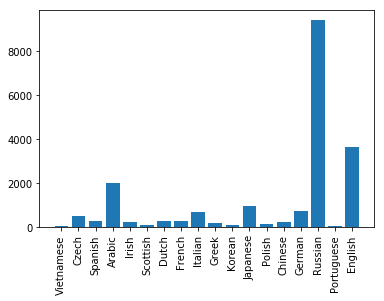

Vietnamese 73
Czech 519
Spanish 298
Arabic 2000
Irish 232
Scottish 100
Dutch 297
French 277
Italian 709
Greek 203
Korean 94
Japanese 991
Polish 139
Chinese 268
German 724
Russian 9408
Portuguese 74
English 3668


In [9]:
labels = list(category_names_dict.keys())
values = [len(names) for names in category_names_dict.values()]

plt.xticks(rotation=90)
centers = range(len(values))
plt.bar(centers, values, align='center', tick_label=labels)
plt.show()

for i,ll in enumerate(labels):
    print(ll,values[i])

[Vietnamese]
Vietnamese
True
Adding  Vietnamese 73
73
---------------
[Czech]
Czech
True
Adding  Czech 519
592
---------------
[Spanish]
Spanish
True
Adding  Spanish 298
890
---------------
[Arabic]
Arabic
True
Adding  Arabic 2000
2890
---------------
[Irish]
Irish
True
Adding  Irish 232
3122
---------------
[Scottish]
Scottish
True
Adding  Scottish 100
3222
---------------
[Dutch]
Dutch
True
Adding  Dutch 297
3519
---------------
[French]
French
True
Adding  French 277
3796
---------------
[Italian]
Italian
True
Adding  Italian 709
4505
---------------
[Greek]
Greek
True
Adding  Greek 203
4708
---------------
[Korean]
Korean
True
Adding  Korean 94
4802
---------------
[Japanese]
Japanese
True
Adding  Japanese 991
5793
---------------
[Polish]
Polish
True
Adding  Polish 139
5932
---------------
[Chinese]
Chinese
True
Adding  Chinese 268
6200
---------------
[German]
German
True
Adding  German 724
6924
---------------
[Russian]
skip
------------------
[Portuguese]
Portuguese
True
Adding

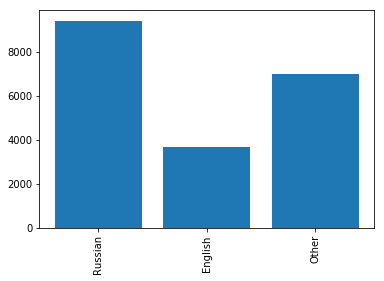

Russian 9408
English 3668
Other 6998


In [10]:
category_names_dict['Other'] = []
to_skip = ['English','Russian','Other']
for k,v in category_names_dict.items():
    print('['+k,']',sep='')
    k = k.strip()
    if k not in to_skip:
        print(k)
        print(k is not 'English' and k is not 'Russian')
        print('Adding ',k,len(v))
        category_names_dict['Other'].extend(v)
        print(len(category_names_dict['Other']))
        print('---------------')
    else:
        print('skip')
        print('------------------')
        
category_names_dict = {i:category_names_dict[i] for i in category_names_dict if i in to_skip}

labels = list(category_names_dict.keys())
values = [len(names) for names in category_names_dict.values()]

plt.xticks(rotation=90)
centers = range(len(values))
plt.bar(centers, values, align='center', tick_label=labels)
plt.show()

for i,ll in enumerate(labels):
    print(ll,values[i])
    
all_categories = list(category_names_dict.keys())
n_categories = len(all_categories)

In [11]:
print(all_categories)
print(n_categories)

['Russian', 'English', 'Other']
3


In [12]:
# Find char index from all_chars, e.g. "a" = 0
def charToIndex(char):
    return all_chars.find(char)

# Just for demonstration, turn a char into a <1 x n_chars> Tensor
def charToTensor_one_hot(char):
    tensor = np.zeros((1, n_chars))
    tensor[0][charToIndex(char)] = 1
    return tensor

def charToTensor(char):
    tensor = np.zeros(1,dtype=np.long)
    tensor[0] = charToIndex(char)
    return tensor

# Turn a line into a <line_length x 1 x n_chars>,
# or an array of one-hot char vectors
def seqToTensor_one_hot(seq):
    tensor = np.zeros((len(seq),1, n_chars))
    for idx, char in enumerate(seq):
        tensor[idx][0][charToIndex(char)] = 1
    return tensor

def seqToTensor(seq):
    tensor = np.zeros(len(seq), dtype=np.long)
    for idx, char in enumerate(seq):
        tensor[idx] = int(charToIndex(char))
    return tensor


print('J=',charToTensor_one_hot('J').shape)

print('Jones=',seqToTensor_one_hot('Jones').shape)

print('\n pad_char=',pad_char,charToTensor_one_hot(pad_char))

J= (1, 58)
Jones= (5, 1, 58)

 pad_char= # [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


### Batch data generator

In [13]:
def batch_data_generator(all_categories, category_names_dict, batch_size, n_chars, pad_char, shuffle):
    
    #flatten the dictionary to a list of tuples.
    dict_tuples = []
    for category,names in category_names_dict.items():
        for nm in names:
            dict_tuples.append((category,nm))
    
    num_samples = len(dict_tuples)
    num_batches = num_samples // batch_size
    
    print('batch_data_generator: num_samples =',num_samples,'num_batches = ',num_batches)
    
    epoch_num = 0
    n_cat = len(category_names_dict)
    
    while(True):
        
        if shuffle:
            random.shuffle(dict_tuples)
            random.shuffle(dict_tuples)
        indices = np.arange(num_samples)
        
        for batch_id in range(num_batches): #for each batch of names
            batch_indices = indices[batch_id * batch_size : (batch_id + 1) * batch_size]

            max_seqlen = 0 #max length of names in a batch.
            batch_names = []
            batch_labels = []
            batch_categories = []    
            name_tensors = []
            
            for b_ind in batch_indices:
                a_name = dict_tuples[b_ind][1]            #'Alex'
                category = dict_tuples[b_ind][0]          #'English'
                label = all_categories.index(category)    #17
                name_tensor = seqToTensor_one_hot(a_name)
                max_seqlen = name_tensor.shape[0] if name_tensor.shape[0] >= max_seqlen else max_seqlen
                batch_names.append(a_name)
                batch_labels.append(label)
                batch_categories.append(category)
                name_tensors.append(np.squeeze(name_tensor))

            #for nt in name_tensors:    
            #    print('name_tensor=',nt.shape)
                
            #convert the batch list of tuples to tensors.
            #Put all the selected names into a single tensor for input to RNN          
            pad_char_tensor = charToTensor_one_hot(pad_char) #tensor corresponding to pad_char            
            #create a tensor of size [batch_size x max_seqlen x n_char] filled with pad_char
            batch_names_tensor = np.broadcast_to(
                pad_char_tensor,(batch_size, max_seqlen, pad_char_tensor.shape[1])
                ).copy()
            
            #print('batch_names_tensor',batch_names_tensor.shape)
            
            for i,name_tensor in enumerate(name_tensors):
                num_chars = name_tensor.shape[0]
                #print(num_chars,'assigning',name_tensor.shape,'to',batch_names_tensor[i,0:num_chars,:].shape)
                batch_names_tensor[i,-num_chars:,:] = name_tensor #Left padding is done with pad_char
            
            batch_names_tensor = np.array(np.squeeze(batch_names_tensor))
            
            batch_labels_one_hot = np.array(to_categorical(batch_labels, num_classes=n_cat))
            
            yield(batch_names_tensor, batch_labels_one_hot)
            
        #done looping through all batches.
        #go to the top and permute the file indices.
        epoch_num += 1

In [14]:
print('Number of name categories, this is the no. of output categories = ',n_categories)

Number of name categories, this is the no. of output categories =  3


### Generate 1 batch of data to test Keras model building

In [15]:
n_hidden = 4
batch_size = 5
shuffle = True

batch_generator = batch_data_generator(all_categories, category_names_dict, batch_size, n_chars, pad_char, shuffle)
batch_names_tensor, batch_labels_tensor_one_hot = next(batch_generator)

print("batch_names_tensor",batch_names_tensor.shape)
print("batch_labels_tensor_one_hot",batch_labels_tensor_one_hot.shape)

print("\nbatch_labels_tensor_one_hot =\n",batch_labels_tensor_one_hot)

batch_data_generator: num_samples = 20074 num_batches =  4014
batch_names_tensor (5, 10, 58)
batch_labels_tensor_one_hot (5, 3)

batch_labels_tensor_one_hot =
 [[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


## A way to use Keras to build a model for character level LSTM

In [16]:
def build_model_1(n_hidden, n_chars, n_categories):
    inputs = Input(shape=(None, n_chars)) #n_chars = feature size
    lstm = LSTM(n_hidden)(inputs)
    dense = Dense(n_categories, activation='softmax')(lstm)
    model = Model(inputs=inputs, outputs=dense)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    #initialize hidden states, not sure if the initialization works.
    #layer[1] is LSTM
    hidden_states = K.variable(value=np.zeros([1, n_hidden]))
    cell_states = K.variable(value=np.zeros([1, n_hidden]))
    model.layers[1].states[0] = hidden_states
    model.layers[1].states[1] = cell_states 
    
    # This initialization also compiles without errors. 
    #c_0 = tf.convert_to_tensor(np.zeros([1, n_hidden]).astype(np.float32))
    #h_0 = tf.convert_to_tensor(np.zeros([1, n_hidden]).astype(np.float32))
    #model.layers[1].states[0] = h_0
    #model.layers[1].states[1] = c_0

    print('--------------Model summary--------------')
    model.summary()
    return model

model1 = build_model_1(n_hidden, n_chars, n_categories)
X_input = tf.placeholder(tf.float32, shape=(None, None, n_chars))
y_output = model1(X_input)

X = batch_names_tensor
y_true = batch_labels_tensor_one_hot

y_pred = model1.predict(X)
print('y_pred = \n',y_pred)

--------------Model summary--------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 58)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 1008      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 15        
Total params: 1,023
Trainable params: 1,023
Non-trainable params: 0
_________________________________________________________________
y_pred = 
 [[0.3196215  0.3282915  0.35208696]
 [0.3212379  0.32976478 0.3489973 ]
 [0.32440522 0.34431443 0.33128032]
 [0.35378945 0.349261   0.29694957]
 [0.30627587 0.33516407 0.35856003]]


### Print predictions and accuracy comparing with true labels

In [17]:
sess = K.get_session()
top_n, top_i = tf.nn.top_k(y_pred, k=1)
top_values, top_indices = sess.run(tf.nn.top_k(y_pred, k=1))
print('y_pred      = ',np.squeeze(top_indices))

batch_labels_tensor = np.argmax(batch_labels_tensor_one_hot,axis=1)
print('true_labels = ',batch_labels_tensor)

#Calculate accuracy of each prediction using Keras metrics
metric = tf.keras.metrics.categorical_accuracy(y_true,y_pred)
print('Accuracy = ',sess.run(metric))

y_pred      =  [2 2 1 0 2]
true_labels =  [0 2 1 2 1]
Accuracy =  [0. 1. 1. 0. 0.]


## Another way to use Keras to build a model for character level LSTM

In [18]:
def build_model_2(n_hidden, n_chars, n_categories):
    model = Sequential()
    lstm = LSTM(n_hidden, input_shape=(None,n_chars)) #n_chars = feature size.
    model.add(lstm)
    model.add(Dense(n_categories, activation='softmax'))
    
    #initialize hidden states, not sure if the initialization works.
    #layer[0] is LSTM
    hidden_states = K.variable(value=np.zeros([1, n_hidden]))
    cell_states = K.variable(value=np.zeros([1, n_hidden]))
    model.layers[0].states[0] = hidden_states
    model.layers[0].states[1] = cell_states 
    
    model.summary()
    return model



model2 = build_model_2(n_hidden, n_chars, n_categories)
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

X_input = tf.placeholder(tf.float32, shape=(None, None, n_chars))
y_output = model2(X_input)

X = batch_names_tensor
y_true = batch_labels_tensor_one_hot

y_pred = model2.predict(X)
print('y_pred = \n',y_pred)


"\nmodel2 = build_model_2(n_hidden, n_chars, n_categories)\nmodel2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])\n\nX_input = tf.placeholder(tf.float32, shape=(None, None, n_chars))\ny_output = model2(X_input)\n\nX = batch_names_tensor\ny_true = batch_labels_tensor_one_hot\n\ny_pred = model2.predict(X)\nprint('y_pred = \n',y_pred)\n"

### Print predictions and accuracy comparing with true labels

In [ ]:
sess = K.get_session()
top_n, top_i = tf.nn.top_k(y_pred, k=1)
top_values, top_indices = sess.run(tf.nn.top_k(y_pred, k=1))
print('y_pred      = ',np.squeeze(top_indices))

batch_labels_tensor = np.argmax(batch_labels_tensor_one_hot,axis=1)
print('true_labels = ',batch_labels_tensor)

#Calculate accuracy of each prediction using Keras metrics
metric = tf.keras.metrics.categorical_accuracy(y_true,y_pred)
print('Accuracy = ',sess.run(metric))

## Train model using SGD

In [19]:
n_hidden = 128
batch_size = 10
shuffle = True

batch_generator = batch_data_generator(all_categories, category_names_dict, batch_size, n_chars, pad_char, shuffle)
batch_names_tensor, batch_labels_tensor_one_hot = next(batch_generator)

print("batch_names_tensor",batch_names_tensor.shape)
print("batch_labels_tensor_one_hot",batch_labels_tensor_one_hot.shape)

print("\nbatch_labels_tensor_one_hot =\n",batch_labels_tensor_one_hot)


my_opt = SGD(lr = 0.0001)

mmodel = build_model_2(n_hidden, n_chars, n_categories)    
mmodel.compile(loss='categorical_crossentropy', optimizer=my_opt, metrics=['accuracy'])

    
mmodel.fit_generator(
          generator=batch_generator,
          steps_per_epoch= 20074 // batch_size,
          epochs=20)

batch_data_generator: num_samples = 20074 num_batches =  2007
batch_names_tensor (10, 11, 58)
batch_labels_tensor_one_hot (10, 3)

batch_labels_tensor_one_hot =
 [[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               95744     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 96,131
Trainable params: 96,131
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2007/2007 [==============================] - 20s 10ms/step - loss: 1.0940 - acc: 0.3718 0s - loss: 1.0940 - acc: 0.3
Epoch 2/20
2007/2007 [==============================] - 19s 10ms/step - loss: 1.0760 - acc: 0.4694
Epoch 3/20
2007/2007 [==

## Predict on a batch of training data just to see the accuracy

In [20]:
batch_names_tensor, batch_labels_tensor_one_hot = next(batch_generator)
X = batch_names_tensor
y_true = batch_labels_tensor_one_hot

y_pred = mmodel.predict(X)
print('y_pred = \n',y_pred)

sess = K.get_session()
top_n, top_i = tf.nn.top_k(y_pred, k=1)
top_values, top_indices = sess.run(tf.nn.top_k(y_pred, k=1))
print('y_pred      = ',np.squeeze(top_indices))

batch_labels_tensor = np.argmax(batch_labels_tensor_one_hot,axis=1)
print('true_labels = ',batch_labels_tensor)

#Calculate accuracy of each prediction using Keras metrics
metric = tf.keras.metrics.categorical_accuracy(y_true,y_pred)
print('Accuracy = ',sess.run(metric))

y_pred = 
 [[0.47419205 0.17760581 0.34820217]
 [0.47768733 0.1875687  0.33474395]
 [0.46545392 0.18263082 0.3519153 ]
 [0.46246004 0.18976393 0.34777606]
 [0.45360634 0.19432098 0.3520727 ]
 [0.44449282 0.18437581 0.3711314 ]
 [0.4448989  0.1782757  0.37682545]
 [0.46446285 0.18748379 0.3480533 ]
 [0.46217299 0.18325418 0.35457283]
 [0.45085272 0.18284613 0.36630115]]
y_pred      =  [0 0 0 0 0 0 0 0 0 0]
true_labels =  [2 0 1 1 2 2 2 2 2 2]
Accuracy =  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


## Train model using Nadam

In [21]:
my_opt = Nadam(lr=0.0001,
              beta_1=0.9,
              beta_2=0.999,
              epsilon=1e-8,
              schedule_decay=0.004)

mmodel = build_model_2(n_hidden, n_chars, n_categories)    
mmodel.compile(loss='categorical_crossentropy', optimizer=my_opt, metrics=['accuracy'])

    
mmodel.fit_generator(
          generator=batch_generator,
          steps_per_epoch= 20074 // batch_size,
          epochs=20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               95744     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 96,131
Trainable params: 96,131
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
2007/2007 [==============================] - 21s 10ms/step - loss: 0.8018 - acc: 0.6484
Epoch 2/20
2007/2007 [==============================] - 21s 10ms/step - loss: 0.6131 - acc: 0.7387
Epoch 3/20
2007/2007 [==============================] - 21s 10ms/step - loss: 0.5453 - acc: 0.7742
Epoch 4/20
2007/2007 [==============================] - 21s 10ms/step - loss: 0.5141 - acc: 0.7872
Epoch 5/20
2007/2007 [==============================] - 21s 11ms/step - loss: 0.4953 - acc: 0.7951
Epoch 6/20
2007/2007 [=================

## Predict on a batch of training data just to see the accuracy

In [23]:
batch_names_tensor, batch_labels_tensor_one_hot = next(batch_generator)
X = batch_names_tensor
y_true = batch_labels_tensor_one_hot

y_pred = mmodel.predict(X)
print('y_pred = \n',y_pred)

sess = K.get_session()
top_n, top_i = tf.nn.top_k(y_pred, k=1)
top_values, top_indices = sess.run(tf.nn.top_k(y_pred, k=1))
print('y_pred      = ',np.squeeze(top_indices))

batch_labels_tensor = np.argmax(batch_labels_tensor_one_hot,axis=1)
print('true_labels = ',batch_labels_tensor)

#Calculate accuracy of each prediction using Keras metrics
metric = tf.keras.metrics.categorical_accuracy(y_true,y_pred)
print('Accuracy = ',sess.run(metric))

y_pred = 
 [[5.34338713e-01 1.45338097e-04 4.65515912e-01]
 [6.53709888e-01 1.18592076e-01 2.27698028e-01]
 [9.99956131e-01 4.31557010e-06 3.95785100e-05]
 [8.01142305e-02 5.97447157e-01 3.22438627e-01]
 [3.10353450e-02 2.87276834e-01 6.81687832e-01]
 [9.99530435e-01 3.51038325e-04 1.18538788e-04]
 [1.15735158e-01 3.28714401e-02 8.51393402e-01]
 [9.99712646e-01 8.49747448e-06 2.78907421e-04]
 [9.97492909e-01 2.08451020e-04 2.29862332e-03]
 [9.99835610e-01 5.13850682e-05 1.12933209e-04]]
y_pred      =  [0 0 0 1 2 0 2 0 0 0]
true_labels =  [0 0 0 1 1 0 2 0 0 0]
Accuracy =  [1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
